# Desafío Kaggle tarea 1 INF 395

In [1]:
!pip install -q keras-core
!pip install -q scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 6.7 MB/s eta 0:00:00


## Integrantes:

* Nombre:
* Nombre:
* Nombre:

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import math
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import random

# Aquí se escoge el backend de keras
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'

import keras_core as keras
from tensorflow.keras.callbacks import EarlyStopping

SEED = 42
keras.utils.set_random_seed(SEED)

Using TensorFlow backend


## Helper Functions

In [3]:
def plot_losses(history, loss):
  "Función para graficar la función de pérdida del modelo"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

## Carga de datos

In [4]:
df = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')

## Anális exploratorio

In [5]:
df

,ID,date,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
0,143,20140515T000000,98003,47.2857,-122.300,3.0,2.25,1590.0,7748.0,2.0,...,0.0,4.0,7.0,1590.0,0.0,1991.0,0.0,1590.0,7606.0,263000.0
1,1175,20141203T000000,98117,47.6885,-122.380,3.0,NaN,2040.0,4005.0,NaN,...,0.0,4.0,8.0,1740.0,300.0,1930.0,0.0,1380.0,4005.0,620000.0
2,221,20140711T000000,98106,47.5150,-122.359,2.0,1.00,640.0,7768.0,1.0,...,0.0,3.0,6.0,640.0,0.0,1942.0,0.0,NaN,7424.0,165000.0
3,1231,20141117T000000,98144,47.5758,-122.309,2.0,1.50,1240.0,NaN,NaN,...,0.0,NaN,8.0,1080.0,160.0,NaN,0.0,1530.0,1209.0,403000.0
4,509,20150402T000000,98038,47.3531,-122.017,3.0,NaN,1990.0,NaN,2.0,...,NaN,3.0,7.0,1990.0,0.0,2010.0,0.0,2580.0,3800.0,318200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,954,20150423T000000,98014,47.6820,-121.913,3.0,2.50,3230.0,129578.0,1.0,...,0.0,NaN,NaN,2100.0,1130.0,NaN,0.0,2760.0,62059.0,499950.0
1272,104,20150507T000000,98103,47.6857,-122.353,4.0,1.50,NaN,4000.0,1.5,...,2.0,NaN,7.0,1580.0,NaN,1920.0,1990.0,1160.0,4000.0,750000.0
1273,138,20140911T000000,98003,47.2827,-122.302,3.0,NaN,NaN,6600.0,NaN,...,NaN,3.0,7.0,1610.0,0.0,NaN,0.0,1660.0,NaN,250000.0
1274,1529,20140509T000000,98075,47.5884,-122.086,3.0,2.25,3000.0,11665.0,1.5,...,4.0,3.0,11.0,3000.0,0.0,2001.0,0.0,3000.0,15959.0,2400000.0


In [6]:
df.dtypes

ID                 int64
date              object
zipcode            int64
lat              float64
long             float64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors           float64
waterfront       float64
view             float64
condition        float64
grade            float64
sqft_above       float64
sqft_basement    float64
yr_built         float64
yr_renovated     float64
sqft_living15    float64
sqft_lot15       float64
price            float64
dtype: object

In [7]:
pd.to_datetime(df['date'])

0      2014-05-15
1      2014-12-03
2      2014-07-11
3      2014-11-17
4      2015-04-02
          ...    
1271   2015-04-23
1272   2015-05-07
1273   2014-09-11
1274   2014-05-09
1275   2014-07-18
Name: date, Length: 1276, dtype: datetime64[ns]

In [8]:
# Check for null values by column
df.isna().sum()

ID                 0
date               0
zipcode            0
lat                0
long               0
bedrooms         202
bathrooms        197
sqft_living      194
sqft_lot         189
floors           192
waterfront       200
view             194
condition        181
grade            190
sqft_above       187
sqft_basement    183
yr_built         163
yr_renovated     201
sqft_living15    189
sqft_lot15       196
price              0
dtype: int64

In [9]:
df['yr_renovated'].unique()

array([   0., 1983.,   nan, 1971., 1996., 1985., 1990., 2014., 1982.,
       1979., 2003., 1986., 2004., 2006., 1997., 1955., 2013., 2001.,
       2000., 1972., 1940., 1989., 2007., 1991., 2005., 1995., 2012.,
       2015., 2011., 1973., 1980., 1958., 1962.])

## Preprocesamiento

In [10]:
df['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)
df['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df['sqft_living'].fillna(df['sqft_living'].median(), inplace=True)
df['sqft_lot'].fillna(df['sqft_lot'].median(), inplace=True)
df['floors'].fillna(df['floors'].median(), inplace=True)
df['waterfront'].fillna(df['waterfront'].median(), inplace=True)
df['view'].fillna(df['view'].median(), inplace=True)
df['condition'].fillna(df['condition'].median(), inplace=True)
df['grade'].fillna(df['grade'].median(), inplace=True)
df['sqft_above'].fillna(df['sqft_above'].median(), inplace=True)
df['sqft_basement'].fillna(df['sqft_basement'].median(), inplace=True)
df['yr_built'].fillna(df['yr_built'].median(), inplace=True)
df['yr_renovated'].fillna(0, inplace=True)
df['sqft_living15'].fillna(df['sqft_living15'].median(), inplace=True)
df['sqft_lot15'].fillna(df['sqft_lot15'].median(), inplace=True)

In [11]:
df_test['bedrooms'].fillna(df['bedrooms'].median(), inplace=True)
df_test['bathrooms'].fillna(df['bathrooms'].median(), inplace=True)
df_test['sqft_living'].fillna(df['sqft_living'].median(), inplace=True)
df_test['sqft_lot'].fillna(df['sqft_lot'].median(), inplace=True)
df_test['floors'].fillna(df['floors'].median(), inplace=True)
df_test['waterfront'].fillna(df['waterfront'].median(), inplace=True)
df_test['view'].fillna(df['view'].median(), inplace=True)
df_test['condition'].fillna(df['condition'].median(), inplace=True)
df_test['grade'].fillna(df['grade'].median(), inplace=True)
df_test['sqft_above'].fillna(df['sqft_above'].median(), inplace=True)
df_test['sqft_basement'].fillna(df['sqft_basement'].median(), inplace=True)
df_test['yr_built'].fillna(df['yr_built'].median(), inplace=True)
df_test['yr_renovated'].fillna(0, inplace=True)
df_test['sqft_living15'].fillna(df['sqft_living15'].median(), inplace=True)
df_test['sqft_lot15'].fillna(df['sqft_lot15'].median(), inplace=True)

In [12]:
df.isna().sum()

ID               0
date             0
zipcode          0
lat              0
long             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
sqft_living15    0
sqft_lot15       0
price            0
dtype: int64

In [13]:
df['date'] = pd.to_datetime(df['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

In [14]:
df.sort_values(by='date', inplace=True)

In [15]:
df['year'] = df['date'].dt.year
df_test['year'] = df_test['date'].dt.year

In [16]:
df['day_of_year'] = df['date'].dt.dayofyear
df_test['day_of_year'] = df_test['date'].dt.dayofyear

In [17]:
df.drop('date', axis=1, inplace=True)
df_test.drop('date', axis=1, inplace=True)

## Feature Engineering

### Preprocess time

In [18]:
def preprocess_time(df, column, period):
    df['sin_' + column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_' + column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)

In [19]:
preprocess_time(df, 'day_of_year', 365)
preprocess_time(df_test, 'day_of_year', 365)

In [20]:
df.drop('ID', axis=1, inplace=True)
df_test_id = df_test['ID']
df_test.drop('ID', axis=1, inplace=True)

## Separación de datos a predecir

In [21]:
def split_features_from_target(df):
    X = df.drop(columns=["price"])
    y = df[["price"]]
    return X, y

In [22]:
X, y = split_features_from_target(df)

## Búsqueda de hiperparámetros

In [27]:
def create_model(layers=1, neurons=8):
    inputs = keras.Input(shape=X.shape[1:])
    hidden_layer = keras.layers.Dropout(0.1)(inputs)

    for _ in range(layers):
      hidden_layer = keras.layers.Dense(neurons, activation='relu')(hidden_layer)
      hidden_layer = keras.layers.Dropout(0.2)(hidden_layer)

    outputs = keras.layers.Dense(y.shape[1])(hidden_layer)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [28]:
split = int(len(X) * 0.6)
x_train = X.iloc[:split]
y_train = y.iloc[:split]
x_val = X.iloc[split:]
y_val = y.iloc[split:]

In [30]:
epochs = 100
early_stopping = EarlyStopping(
  monitor='val_loss',
  min_delta=0.001,
  patience=10,
  restore_best_weights=True
)

params = {
    'layers': [1, 2, 3],
    'neurons': [8, 48, 128, 256, 512],
    'batch_size': [32, 64, 128]
}

best_result = -1
best_parms = None

for layer in params['layers']:
  for neuron in params['neurons']:
    for batch_size in params['batch_size']:
      current_params = {'layers': layer, 'neurons': neuron, 'batch_size': batch_size}
      print(current_params)
      model = create_model(layers=layer, neurons=neuron)

      model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        verbose=0,
        callbacks=[early_stopping]
      )

      mse = mean_squared_error(y_val, model.predict(x_val))

      if mse < best_result or best_result == -1:
        best_result = mse
        best_params = current_params

{'layers': 1, 'neurons': 8, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
{'layers': 1, 'neurons': 8, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
{'layers': 1, 'neurons': 8, 'batch_size': 128}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
{'layers': 1, 'neurons': 48, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
{'layers': 1, 'neurons': 48, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
{'layers': 1, 'neurons': 48, 'batch_size': 128}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
{'layers': 1, 'neurons': 128, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
{'layers': 1, 'neurons': 128, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
{'layers': 1, 'neurons': 128, 'batch_size': 128}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
{'layers': 1, 'neurons': 256, 'batch_size': 32}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
{'layers': 1, 'neurons': 256, 'batch_size': 64}
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
{'layers': 1, 'neurons': 256, 'batch_size': 128}


In [31]:
best_params

{'layers': 2, 'neurons': 128, 'batch_size': 64}

## Entrenamiento

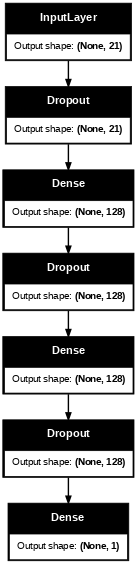

In [33]:
keras.utils.plot_model(create_model(best_params['layers'], best_params['neurons']), show_shapes=True, rankdir="TB", dpi=50)

In [36]:
epochs = 1000
validation_split = 0.1

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    restore_best_weights=True
)

model = create_model(best_params['layers'], best_params['neurons'])

history = model.fit(
    X,
    y,
    batch_size=best_params['batch_size'],
    epochs=epochs,
    validation_split=validation_split,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 378925794142.3158 - val_loss: 255507038208.0000
Epoch 2/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 250179906506.1053 - val_loss: 155825504256.0000
Epoch 3/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 163868874213.0526 - val_loss: 134742908928.0000
Epoch 4/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 151483867998.3158 - val_loss: 112667410432.0000
Epoch 5/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 154080589285.0526 - val_loss: 104097923072.0000
Epoch 6/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 148824549483.7895 - val_loss: 100064804864.0000
Epoch 7/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 143613267321.2632 - val_loss: 97381187584.0000
Epoch 8/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 133929279056.8421 - val_loss: 94675853312.0000
Epoch 9/1000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 139341914543.1579 - val_loss: 94554546176.0000
Epoch 10/1000
18/18 ━━━━━━━━━

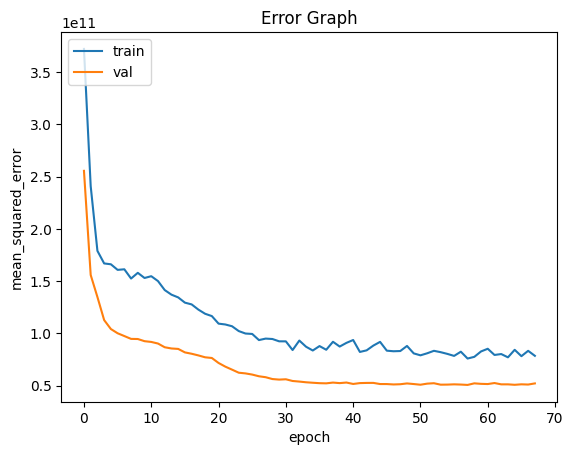

In [37]:
plot_losses(history, keras.losses.MeanSquaredError())

## Predicciones

In [38]:
X_test = df_test
predictions = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [39]:
results = pd.DataFrame()
results['ID'] = df_test_id
results['price'] = predictions
results.to_csv('submission.csv', index=False)